Bayesian Logit Model needs some math.

I followed equations from https://www.cs.ubc.ca/~schmidtm/Documents/2006_Notes_BLogReg.pdf. Read this doc for more information.

The necessary equations are:

\begin{align*}
z_i | w, \lambda &\propto N(x_i^T w, \lambda_i)I(z_i > 0) \quad \text{if } y_i = 1 \\
z_i | w, \lambda &\propto N(x_i^T w, \lambda_i)I(z_i \leq 0) \quad \text{if } y_i \neq 1 \\
w | z, y, \lambda &\sim N(B, V) \\
B &= V (v^{-1}b + X^T W z) \\
V &= (v^{-1} + X^T W X)^{-1} \\
W &= \text{diag}(\lambda^{-1})
\end{align*}



1. Initialize $\beta$ and $z$.

2. For each iteration $i$ from 1 to the total number of samples:

    a. Sample $z_i$ from its full conditional distribution given $\beta$:
    $$\begin{aligned}
    z_i | \beta, y_i = 1 &\sim \text{TruncNorm}(-X_i\beta, \infty) \\
    z_i | \beta, y_i = 0 &\sim \text{TruncNorm}(-\infty, -X_i\beta)
    \end{aligned}$$

    b. Sample $\beta$ from its full conditional distribution given $z$:
    $$\beta | z \sim \text{Norm}((X^TX)^{-1}X^Tz, (X^TX)^{-1})$$

3. Store the sample $\beta$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [4]:
def gibbs_sampler(X, y, num_samples):
    num_data, num_features = X.shape

    # Initialize the parameters and latent variables
    beta = np.zeros(num_features)
    z = np.zeros(num_data)

    # Store the samples
    samples = np.zeros((num_samples, num_features))

    for i in range(num_samples):
        # Sample from the full conditional distribution of z given beta
        mu = np.dot(X, beta)
        v = np.where(y == 1)
        z[v] = truncnorm.rvs(-mu[v], np.inf)
        v = np.where(y == 0)
        z[v] = truncnorm.rvs(-np.inf, -mu[v])

        # Sample from the full conditional distribution of beta given z
        beta = np.random.multivariate_normal(np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, z)), np.linalg.inv(np.dot(X.T, X)))

        # Store the sample
        samples[i] = beta

    return samples

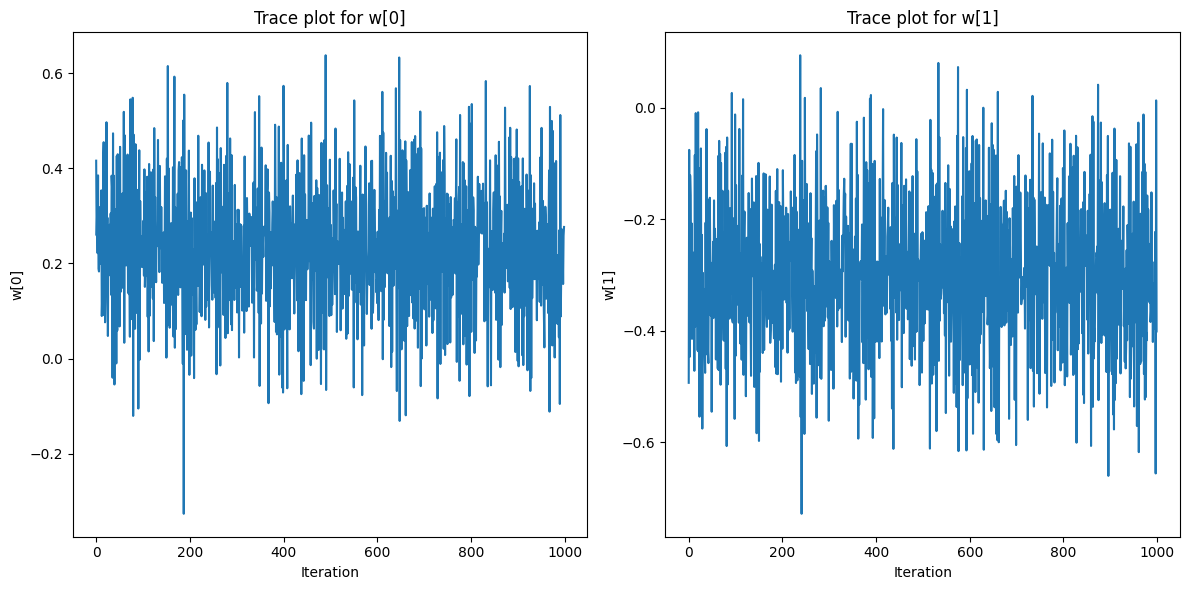

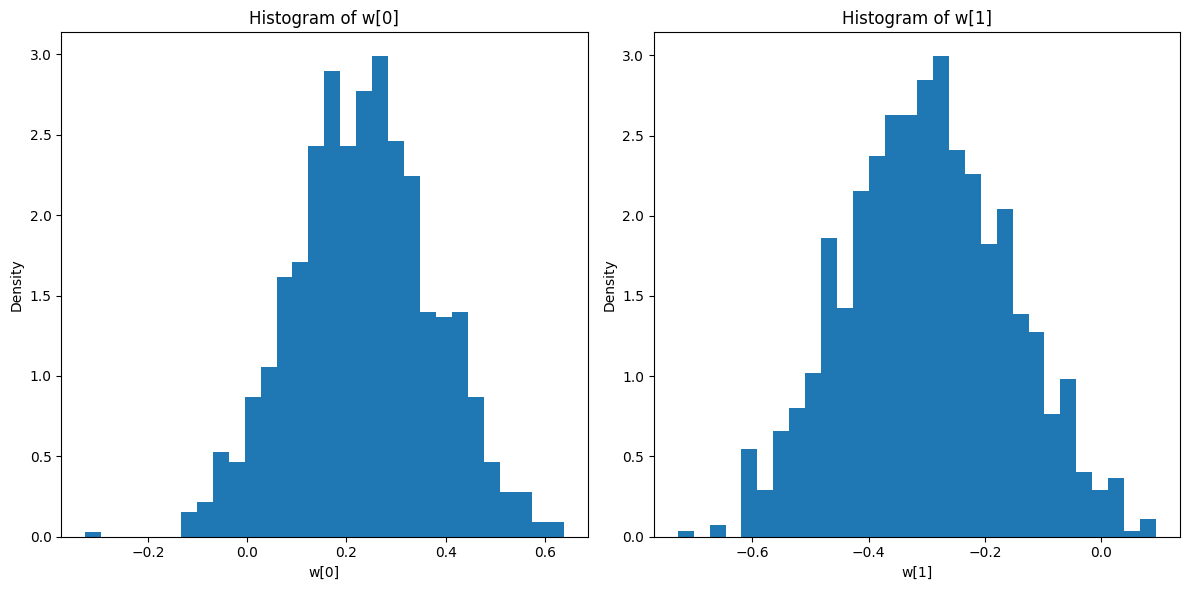

In [6]:
# Generate some synthetic data
np.random.seed(0)
num_data = 100
num_features = 2
X = np.random.normal(size=(num_data, num_features))
true_w = np.array([2, -3])
y = np.random.binomial(1, 1 / (1 + np.exp(-np.dot(X, true_w))))

# Set the hyperparameters
num_samples = 1000
v = 1
b = np.zeros(num_features)

# Run the Gibbs sampler
samples = gibbs_sampler(X, y, num_samples)

# Plot the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.xlabel('Iteration')
plt.ylabel('w[0]')
plt.title('Trace plot for w[0]')

plt.subplot(1, 2, 2)
plt.plot(samples[:, 1])
plt.xlabel('Iteration')
plt.ylabel('w[1]')
plt.title('Trace plot for w[1]')

plt.tight_layout()
plt.show()

# Plot the histogram of the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins=30, density=True)
plt.xlabel('w[0]')
plt.ylabel('Density')
plt.title('Histogram of w[0]')

plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins=30, density=True)
plt.xlabel('w[1]')
plt.ylabel('Density')
plt.title('Histogram of w[1]')

plt.tight_layout()
plt.show()